<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/SbS_Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo de self attention

In [33]:
import torch 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ====
# 0
# ====

# -- ENTRADA:
text = 'Quero um cartão'
text_tokens = ['Quero', 'um', 'cartão']

# -- IDs:
text_ids = [27,11,83] # tokens sintéticos
VOCAB = 100 # Quantidade de palavras - no BERT ~30k

# -- DIMENSÃO DOS EMBEDDINGS = 4:
D = 8

# -- COMPRIMENTO DA SEQUÊNCIA:
L = 3

# -- NÚMERO DE CABEÇAS:
H = 2

# -- MATRIZ DE EMBEDDINGS LxD:
embs  = torch.nn.Embedding(VOCAB, D)

# tensor com zeros_like
embeddings = torch.zeros(len(text_ids) * D).reshape(len(text_ids), D)
print(f'Shape da matriz de embeddings: {embeddings.shape}\n')

print('Matriz de embeddings\n')
for i , token in enumerate(text_ids):
    embeddings[i] = embs(torch.tensor(token))
embeddings

Shape da matriz de embeddings: torch.Size([3, 8])

Matriz de embeddings



tensor([[-0.6716, -0.8052, -1.3753, -0.9598, -0.8162, -1.0743, -1.1493,  1.0052],
        [-1.2672,  0.8590,  0.7650, -0.1225, -0.4680, -0.1172,  0.8682,  0.7488],
        [ 0.0959, -0.7437, -0.8650, -0.1754, -0.2658, -0.7284,  0.4719, -0.9366]],
       grad_fn=<AsStridedBackward>)

In [21]:
# ====
# 1
# ====

# -- MATRIZ DE PESOS, Q, K, V --> DxD (INICIADOS ARBITRARIAMENTE):
Qw = torch.nn.Linear(D, D)
Kw = torch.nn.Linear(D, D)
Vw = torch.nn.Linear(D, D)

print(f'Qw shape: {Qw(embeddings).shape}')
print(f'Kw shape: {Kw(embeddings).shape}')
print(f'Vw shape: {Vw(embeddings).shape}')

Qw shape: torch.Size([3, 8])
Kw shape: torch.Size([3, 8])
Vw shape: torch.Size([3, 8])


In [22]:
# ====
# 2
# ====

# -- OBTER Q, K e V:
print(f'Shape da entrada: {embeddings.size()} -- Shape das Matrizes de pesos Qw, Kw e Vw: {Qw.weight.size()}')

Q =  Qw(embeddings)
K =  Kw(embeddings)
V =  Vw(embeddings)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Shape da entrada: torch.Size([3, 8]) -- Shape das Matrizes de pesos Qw, Kw e Vw: torch.Size([8, 8])
Q torch.Size([3, 8])
K torch.Size([3, 8])
V torch.Size([3, 8])


In [23]:
# ====
# 3
# ====

dk = D//H
Q = Q.reshape(L, H, dk)
K = K.reshape(L, H, dk)
V = V.reshape(L, H, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Q torch.Size([3, 2, 4])
K torch.Size([3, 2, 4])
V torch.Size([3, 2, 4])


In [24]:
# ====
# 4
# ====

Q = Q.transpose(0,1) # (H, L, dk)
K = K.transpose(0,1) # (H, L, dk)
V = V.transpose(0,1) # (H, L, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Q torch.Size([2, 3, 4])
K torch.Size([2, 3, 4])
V torch.Size([2, 3, 4])


In [25]:
# ====
# 5
# ====

# -- CALCULAR O SCORE:    
QKT = torch.einsum('hld, hcd -> hlc', Q, K) # K.transpose(-2,-1)=(H, dk, L) := (H, L, dk)x(H, dk, L) = (H, L, L)
print('SCORE', QKT.size())

# -- DIVIDIR POR SQRT(D)

# -- SOFTMAX:
Softmax = torch.nn.Softmax(dim=-1)
Softmax = Softmax(QKT.float())
SCORE = QKT/torch.sqrt(torch.tensor(D)) # (H, L, L) 

SCORE torch.Size([2, 3, 3])


In [26]:
# ====
# 6
# ====

SV = torch.einsum('hlc, hck -> hlk', SCORE, V) # (H, L, L)x(H, L, D//H)=(H, L, D//H)
print('SV', SV.size()) 

SV torch.Size([2, 3, 4])


In [10]:
# ====
# 7
# ====

SV = SV.transpose(0,1) # (L, H, dk)
print('SV', SV.size())

SV torch.Size([3, 2, 4])


In [27]:
# ====
# 8
# ====

SV = SV.reshape(L, -1) # (L, H*dk)
print('SV', SV.size())

# -- MULTIPLICAR PELA MATRIZ DE PROJEÇÃO Wo
Wow = torch.nn.Linear(D, D)

SV torch.Size([3, 8])


In [30]:
# ====
# 9
# ====

ATT = Wow(SV) # (L, D)x(DxD)
print('ATT', ATT.size())
ATT

ATT torch.Size([3, 8])


tensor([[-0.4000, -0.1559,  0.0980,  0.0197, -0.1930, -0.0946,  0.0861,  0.2356],
        [-0.3483, -0.2536, -0.0386, -0.0334, -0.1852, -0.0282,  0.1177,  0.1838],
        [-0.3642, -0.2463,  0.1017,  0.1852, -0.1552, -0.2865,  0.1589,  0.0547]],
       grad_fn=<AddmmBackward>)

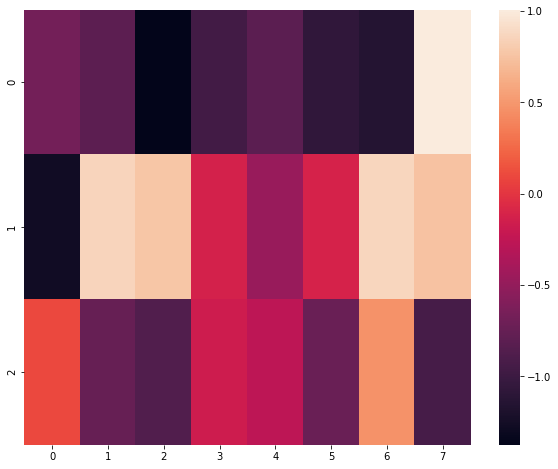

In [37]:
# Embs sem ATT
plt.figure(figsize=(10,8))
sns.heatmap(embeddings.detach().numpy())
plt.savefig('semAtt.png')

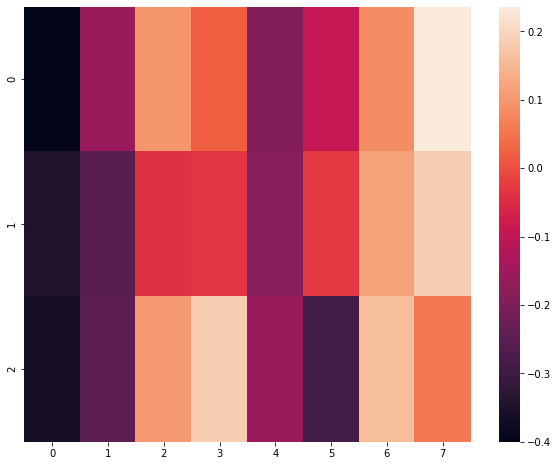

In [38]:
# ATT Embs
plt.figure(figsize=(10,8))
sns.heatmap(ATT.detach().numpy())
plt.savefig('comAtt.png')

# Fim do Notebook